# Real Time Background Changing With OpenCV and Python

## Introduction
This is going to be our first project on the series `#7daysofcomputervisionproject`and the entire series is targeted to you if you are beginner or experienced but want to try something for fun. 

With state of the art methods, the background can be changed easily and perfectly. We have video calling platforms like Zoom and Facebook's messenger which allows us to change our background on realtime with some level of realistic experience. My goal here is not to make something like those giants provided but to use simple concept of image processing and achieve some level of background changing.

I will be trying few concepts and ideas along with some experiments on the way. 

## Preliminary Tasks

### Import Libraries 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Define Common Function
I don't know why I always define this function at first.


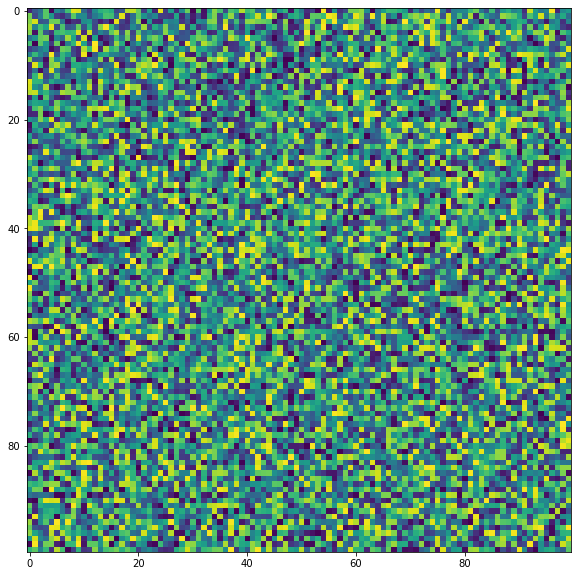

In [2]:
def show(img, fsize=(10,10)):
    figure=plt.figure(figsize=fsize)
    plt.imshow(img)
    plt.show()
show(np.random.randint(0, 255, (100, 100)))

## Experiment 1: Use Background Substraction Concept
Background Subtraction is really fun and tricky task and it is simple too. The core concept is that we will start by picking a scene or the image in which we want our object to be placed on. Then we will take a image where will be a object and its background too. Then if we have the background image as a seperate image, then we can subtract background from the original image and get the mask of an object. Now we will change the pixels on scene image at those position, where the mask of object lies on. The mask will be non zero and we can easily find that. We will change the pixel value to the value of object on those non zero position of mask.

Lets try it first with some dummy image.

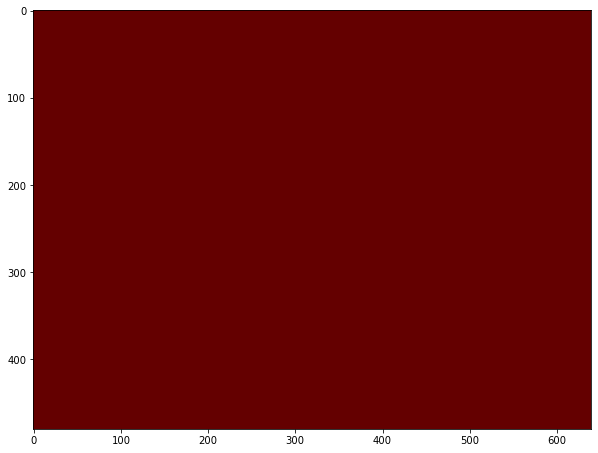

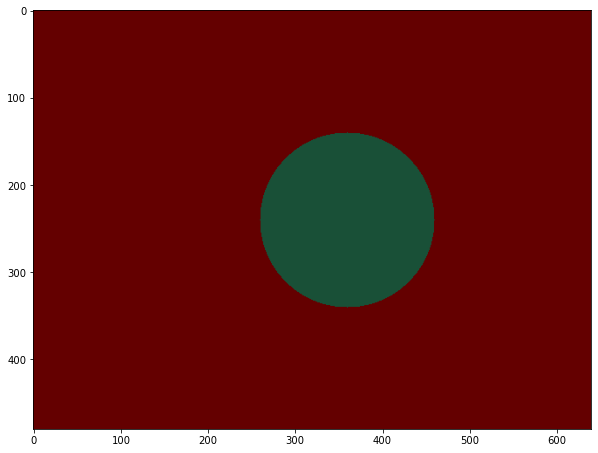

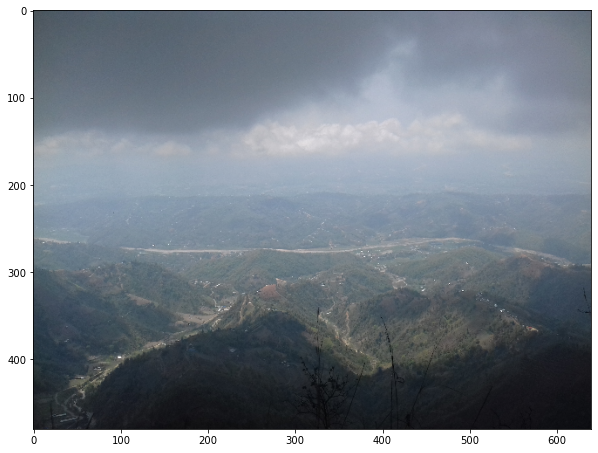

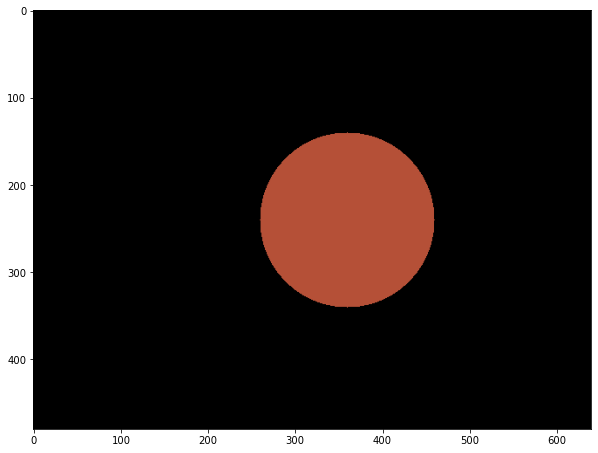

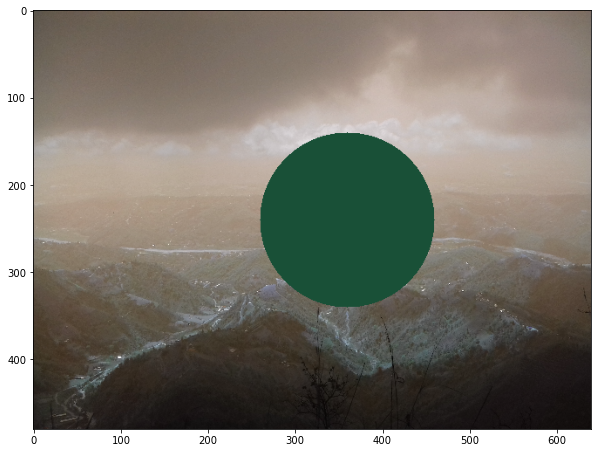

In [3]:
# create one empty image then add some background color
bg = np.zeros((480, 640, 3))
bg[:, :, 0]+=100 # red color increase
bg = bg.astype(np.uint8)

show(bg)

# make copy of bg and then add object on it
img = bg.copy()

# make circle on it :) object!
cv2.circle(img, (360, 240), 100, (25, 80, 55), -1)
show(img)

# read a scene image
scene = cv2.imread("scene.jpg", -1)
scene = cv2.resize(scene, (img.shape[1], img.shape[0]))
rgb_scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
show(rgb_scene)

# how to add the circle on the scene?
mask = img-bg # subtract background from image
show(mask)

# now apply mask to scene
res = scene.copy()
res[mask!=0] = img[mask!=0]
show(res)

Above example was very basic and we would perform this concept as the backbone for some of upcoming experiments.

### Function to Do Running Average
In our live camera feed, we will not be able to distinguish between background and foreground color because the color combination can be different. Hence we will start by making background image for upto few frames. We will take a running average of each frame for some frames and then start the background subtraction. And then we will apply the background subtraction concept to insert scene on our background. 


In [4]:
def running_average(bg_img, image, aweight):
    if bg_img is None:
        bg_img = image.copy().astype("float")
    else:
        cv2.accumulateWeighted(image, bg_img, aweight)    
    return bg_img


### Background Subtraction: Only Static Objects on the Background

Please refer to the comment on each line for the explanation of the code.

We are using new background as below image.
![image](scene.jpg)

In [7]:
# read camera feed
cam = cv2.VideoCapture(0)
notify_num = 200 # up to how many frames to take background average.
frame_count=0 # a variable to count current frame

aweight = 0.5 # variable used to take average
bg = None # background image
take_bg=True # 

scene = cv2.imread("scene.jpg") # read the scene image
scene = cv2.resize(scene, (640, 480)) # resize scene to the size of frame

while True: # loop until termination
    ret, frame = cam.read() # read frame
    frame= cv2.flip(frame, 1) # flip the frame to make frame like mirror image
    clone = frame.copy() # make a local copy of frame
    

    gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY) # convert frame to grayscale
    gray = cv2.medianBlur(gray, 5) # add some median blur to remove Salt and Pepper noise
    
    key = cv2.waitKey(1) & 0xFF # listen for the key event
    
    if key == 27: # if hit escape key
        break # break out of the loop
        
    
    if take_bg == True and notify_num>frame_count: # condition to take a background average
        txt = f"Taking background, Hold Still: {str(notify_num-frame_count)}"
        
        cv2.putText(clone, txt, (10, 50),
                                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        bg=running_average(bg, gray, aweight) # call the running average function to get the average on each frame
    else:
        take_bg= False # don't take background average now!
        frame_count=0 # set frame count to 0
        
        diff = cv2.absdiff(bg.astype("uint8"), gray) # get the absolute difference of background image and current image
        diff[diff<30]=0 # threshold it little bit
        f = clone.copy() # again make a loval copy 
        f[diff==0] = scene[diff==0] # image masking !!!!!
        cv2.imshow("Subtraction", f) # show the background subtracted image.
        

    frame_count+=1
    cv2.imshow("Output", clone)
cam.release()
cv2.destroyAllWindows()


**Output**
<figure>
<video src = "exmp1.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Using Running Average</figcaption>
</figure> 


> In order to run this code properly, don't get in front of the camera until the background has been taken. This way our background will be only static objects like wall and posters.

### Drawbacks of Current Code
* First is that we can not stay in front of the camera while taking average.

In order to eliminate above drawback, we can start with defining a ROI, a region of interest which will represent our background. For this concept to work, it is **essential** to have background in plain color.

### Background Subtraction: ROI for Background

In [113]:
# read camera feed
cam = cv2.VideoCapture(0)
notify_num = 200 # up to how many frames to take background average.
frame_count=0 # a variable to count current frame

aweight = 0.5 # variable used to take average
bg = None # background image
take_bg=True # 

fsize = (520, 720)
scene = cv2.imread("scene.jpg") # read the scene image
scene = cv2.resize(scene, (fsize[1], fsize[0])) # resize scene to the size of frame

left,top,right,bottom=(400, 20, 630, 300)


while True: # loop until termination
    ret, frame = cam.read() # read frame
    frame= cv2.flip(frame, 1) # flip the frame to make frame like mirror image
    frame = cv2.resize(frame, (fsize[1], fsize[0]))
    
    clone = frame.copy() # make a local copy of frame

    gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY) # convert frame to grayscale
    gray = cv2.medianBlur(gray, 5) # add some median blur to remove Salt and Pepper noise
    
    
    key = cv2.waitKey(1) & 0xFF # listen for the key event
    
    roi = gray[top:bottom, left:right]
    
    roi = cv2.resize(roi, (fsize[1], fsize[0]))
    
    if key == 27: # if hit escape key
        break # break out of the loop
        
    
    if take_bg == True and notify_num>frame_count: # condition to take a background average
        txt = f"Taking background, Hold Still: {str(notify_num-frame_count)}"
        
        cv2.putText(clone, txt, (10, 50),
                                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.rectangle(clone, (left, top), (right, bottom), (0, 0, 255), 1)
        bg=running_average(bg, roi, aweight) # call the running average function to get the average on each frame
    else:
        take_bg= False # don't take background average now!
        frame_count=0 # set frame count to 0
        
        diff = cv2.absdiff(bg.astype("uint8"), gray) # get the absolute difference of background image and current image
        diff[diff<40]=0 # threshold it little bit
        cv2.imshow("diff", diff.astype("uint8"))
        f = clone.copy() # again make a loval copy 
        f[diff==0] = scene[diff==0] # image masking !!!!!
        cv2.imshow("Subtraction", f) # show the background subtracted image.
        

        
    frame_count+=1
    cv2.imshow("Output", clone)
cam.release()
cv2.destroyAllWindows()


Instead of using entire frame as a background image, I an selecting only some portion of a plain background. And the result is not that bad.

<figure>
<video src = "exmp2.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Using Running Average on ROI</figcaption>
</figure> 

## Experiment 2: Use Thresholding Concept

In [9]:
# read camera feed
cam = cv2.VideoCapture(0)

fsize = (520, 720)
scene = cv2.imread("scene.jpg") # read the scene image
scene = cv2.resize(scene, (fsize[1], fsize[0])) # resize scene to the size of frame


while True: # loop until termination
    ret, frame = cam.read() # read frame
    frame= cv2.flip(frame, 1) # flip the frame to make frame like mirror image
    frame = cv2.resize(frame, (fsize[1], fsize[0]))
    
    clone = frame.copy() # make a local copy of frame

    gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY) # convert frame to grayscale
    gray = cv2.medianBlur(gray, 9) # add some median blur to remove Salt and Pepper noise
    
    
    key = cv2.waitKey(1) & 0xFF # listen for the key event
    
    
    if key == 27: # if hit escape key
        break # break out of the loop
        
    
    kernel = np.ones((7, 7))
    th = cv2.threshold(gray, 40, 255, cv2.THRESH_OTSU)[1]        
    th = cv2.dilate(th, kernel, iterations=1)
    th = cv2.erode(th, kernel, iterations=5)
    
    f = clone.copy()
    
    f[th!=0] = scene[th!=0]
    cv2.imshow("Thresh Result", f)
    
    edges = cv2.Canny(gray, 10, 50)
    kernel = np.ones((3, 3))
    edges = cv2.dilate(edges, kernel, iterations=5)
#     edges = cv2.erode(edges, kernel, iterations=7)
    cv2.imshow("Canny", edges)
    
    (cnts, _) = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    dm = np.zeros_like(edges)    
    if len(cnts)>0:
        mcnt = max(cnts[:], key=cv2.contourArea)
        dm=cv2.fillConvexPoly(dm, mcnt, (255))
        cv2.imshow("DM", dm)
    c = frame.copy()
    c[dm!=255]=scene[dm!=255]
    cv2.imshow("Canny Result", c)
    
cam.release()
cv2.destroyAllWindows()


Above code is fast but it does have many problems like it can not work with dynamic background, there is not a distinct identification of foreground and a background image.

<figure>
<video src = "exmp3.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Using Thresholding</figcaption>

</figure> 

## Experiment 3: MOG2

There are good background subtraction methods available under the OpenCV and those can handle background subtraction pretty greatly. One of them is MOG2.

In [3]:
cam = cv2.VideoCapture(0)
mog = cv2.createBackgroundSubtractorMOG2()

fsize = (520, 720)
scene = cv2.imread("scene.jpg") # read the scene image
scene = cv2.resize(scene, (fsize[1], fsize[0])) # resize scene to the size of frame
    

while True:
    ret, frame = cam.read()
    if ret:
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, (fsize[1], fsize[0]))
        fmask = mog.apply(frame, 0.5)
        
        
        kernel = np.ones((3, 3))  
        fmask = cv2.dilate(fmask, kernel, iterations=1)
#         fmask = cv2.erode(fmask, kernel, iterations=1)
        
        cv2.imshow("mog", fmask)
        
        key = cv2.waitKey(1) & 0xFF 
    
    
        if key == 27: # if hit escape key
            break # break out of the loop
            
        frame[fmask==0] = scene[fmask==0]
        
        cv2.imshow("Frame", frame)
    
cam.release()
cv2.destroyAllWindows()


MOG2 is good background subtraction algorithm for the moving object on static background but in our case it fails. Now we will be moving towards advanced and best tool available.

## Experiment 4: Mediapipe
Mediapipe is a Google's OpenSource tool for doing awesome Computer Vision tasks like Face Detection to Pose Detection. And in this example, I am going to use [Selfie Segmentation](https://google.github.io/mediapipe/solutions/selfie_segmentation.html) Code. 
### Installation
* Do `pip install mediapipe` or Follow the [official instructions](https://google.github.io/mediapipe/getting_started/python.html).



In [11]:
import cv2
import mediapipe as mp
import numpy as np

mp_selfie_segmentation = mp.solutions.selfie_segmentation

cam = cv2.VideoCapture(0)

fsize = (520, 720)
scene = cv2.imread("scene.jpg") # read the scene image
scene = cv2.resize(scene, (fsize[1], fsize[0])) # resize scene to the size of frame


# begin with selfie segmentation model
with mp_selfie_segmentation.SelfieSegmentation(model_selection=1) as selfie_seg:
    bg_image = scene
    
    while cam.isOpened():
        ret, frame = cam.read()
        if not ret:
            print("Error reading frame...")
            continue
        frame = cv2.resize(frame, (fsize[1], fsize[0]))
        
        # flip it to look like selfie camera
        frame = cv2.flip(frame, 1)
        
        
        # get rgb image to pass that on selfie segmentation
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # process it!
        results = selfie_seg.process(rgb) 
        
        # get the condition from result's segmentation mask
        condition = np.stack((results.segmentation_mask, ) * 3, axis=-1) > 0.1
        
        # apply background change if condition matches
        output_image = np.where(condition, frame, bg_image)

        # show the output
        cv2.imshow('Background Change with MP', output_image)
        if cv2.waitKey(5) & 0xFF == 27:
            break
cam.release()
cv2.destroyAllWindows()


<figure>
<video src = "exmp4.mp4" width="100%" controls autoplay loop> </video>
<figcaption style = "text-align:left; font-style:italic">Using Selfie Segmentation</figcaption>
</figure> 

## Conclusion
These were just some experiments and tricks of image processing to do cool thing like changing background on real-time. My own version of experiments were not that good but the Mediapipe result is just awesome. There are other interesting topics and features provided by mediapipe and in the next part, I will be trying them. 

The code and the YouTube video is on the below link.
* Code: [GitHub]()
* YouTube Video: [YouTube]()